# Scénario réaliste
## sysbench oltp read_only
### Caractériser le scénario
#### Description
Le but de cette expérience est d'étudier le comportement de `sysbench` dans un scénario bien défini.

Ce scénario peut-être découpé en 3 parties (correspondant chacune à une exécution de `sysbench` différentes) :
1. Le nombre d'événément envoyé à la base de données n'est pas limité.
2. Le nombre d'événément envoyé à la base de données est limité à 300 transactions par seconde avec l'option `--rate=300` de `sysbench`.
3. Le nombre d'événément envoyé n'est pas limité.
Chacune ce ces parties durent 60 secondes donc le scénario se déroule en 180 secondes.

#### Environnement 
Le conteneurs a été lancé dans une machine virtuelle linux 4.19.5 disposant de 3GB de mémoire et 4 coeurs.

Les accès au disque de la machine virtuelle ne pouvaient pas compter sur le cache fichier du système hôte car celui-ci a été désactivé.

Le conteneur est lancé avec une `max` limite fixée à 3GB et une `soft` limite fixée à 2GB. Il dispose de deux coeurs.
Les différentes exécutions n'ont pas d'impact les unes sur les autres car le cache fichier est vidé entre chaque itération.

#### Algorithme de l'expérience
Les expériences ont été répétées 10 fois afin de calculer une moyenne et l'écart-type associé.

Avant chaque expérience une sauvegarde de la base de données est effectuée afin de ramener celle-ci de force en mémoire et donc gonfler la mémoire du conteneur.
Cette sauvegarde ramenera les données dans le cache fichier du noyau. Ainsi pour accèder à ces données `mysql` n'aura qu'à faire une copie de celles-ci depuis le cache fichier vers son tampon mémoire plutôt que ramener celles-ci depuis le disque.
Cette sauvegarde émule en quelque sorte le fait que `mysql` s'exécute depuis longtemps et a ramené toute la base de données dans sa mémoire.

Le script permettant de lancer l'expérience est le suivant :
```python
#! /usr/bin/env python3
# SPDX-License-Identifier: MPL-2.0
# Copyright (c) 2019 Francis Laniel <francis.laniel@lip6.fr>
import sys
import docker
import os
import threading
import json
import time

"""This python script will start two containers with filebench with the given as
argument soft limits.

It will then run 10 times the SYSBENCH_CONTAINER_A and SYSBENCH_CONTAINER_B in
each container as argument. The output of filebench will be written to a file
and statistics (memory usage in bytes and reads from the disk) will be written
to another file.
"""

# Each run lasts 180 seconds.
DURATION = 180

CHARS = ['A', 'B']

# Containers' DB will be 2G.
# Each will execute with two threads since they have 2 cores.
SYSBENCH_PREPARE_COMMAND = 'sysbench --threads=2 /usr/share/sysbench/oltp_read_only.lua --table_size=10000000 prepare'

# Each experiment will be composed of 3 sysbenchs execution:
# 1. A will execute sysbench without limit and B will limit the rate event to 300 (it is approximately 30% of the unlimited rate).
# 2. This case is case 1 reversed.
# 3. A and B will run sysbench without limiting their rates.
SYSBENCH_RUN_COMMANDS = {'A' : ['sysbench --report-interval=1 --time=60 --threads=2 --rate=0 /usr/share/sysbench/oltp_read_only.lua --table_size=10000000 run', 'sysbench --report-interval=1 --time=60 --threads=2 --rate=300 /usr/share/sysbench/oltp_read_only.lua --table_size=10000000 run', 'sysbench --report-interval=1 --time=60 --threads=2 --rate=0 /usr/share/sysbench/oltp_read_only.lua --table_size=10000000 run'], 'B' : ['sysbench --report-interval=1 --time=60 --threads=2 --rate=300 /usr/share/sysbench/oltp_read_only.lua --table_size=10000000 run', 'sysbench --report-interval=1 --time=60 --threads=2 --rate=0 /usr/share/sysbench/oltp_read_only.lua --table_size=10000000 run', 'sysbench --report-interval=1 --time=60 --threads=2 --rate=0 /usr/share/sysbench/oltp_read_only.lua --table_size=10000000 run']}

# This command is run before each run to force read the whole database and bring
# it in memory.
# WARNING We can not use redirection directly in exec_run. We need to use bash
# to be able to redirect. Thanks Damien for the information and also the
# suggestion of the command.
MYSQL_DUMP_COMMAND = "bash -c 'mysqldump sbtest > /dev/null'"

# Give two virtual core to each container. The virtual core are chosen so they
# are on the same physical core (i.e cache are shared).
CONTAINERS_CPUS_SETS = ['0,2', '1,3']

# Those keys are stored under the stat json object in the memory_stats object.
MEMORY_KEYS = ['active_anon', 'active_file', 'inactive_anon', 'inactive_file', 'unevictable']

# 'io_serviced_recursive' gives the number of read, write, etc. while
# 'io_service_bytes_recursive' gives the number of bytes read, written, etc.
IO_KEYS = ['io_serviced_recursive', 'io_service_bytes_recursive']

# The keys added to a temporary dictionary.
KEYS = ['usage'] + MEMORY_KEYS + ['io_serviced_recursive:Read', 'io_service_bytes_recursive:Read']

def thread_func(container, commands, out, stats):
	"""Run the commands in container and write the output in out.
	This function will be used as a thread.
	:param container: The container in which command will be run. It must already
	been started.
	:type container: docker.models.containers.Container
	:param commands: The commands to run in container.
	:type commands: list of str.
	:param out: An open in write file object where the output of command will be
	written.
	:type out: _io.TextIOWrapper
	:param out: An open in write file object where the stats of the container will
	be written.
	:type out: _io.TextIOWrapper
	"""
	container.exec_run(MYSQL_DUMP_COMMAND)

	gen = container.stats()

	for command in commands:
		# Run the benchmark inside the container and write the output to out.
		# exec_run returns a tuple whom second field contains bytes. The decode
		# translate them to a string.
		out.write(container.exec_run(command)[1].decode('utf-8') + '\n')

	statistics = []
	old_values = {}

	# old_values will be used below, this loop initializes it with 0s and
	# with the good keys.
	for i in KEYS[1 + len(MEMORY_KEYS):]:
		old_values[i] = 0

	for record in gen:
		# Translate the record in string and translate it to python dictionary.
		# Vive la Joz' ! Bon vivant Docteur bon vivant !
		jason = json.loads(record.decode('utf-8'))

		# Create a new dictionary at each iteration so the statistics's cases are
		# differents.
		chicandier = {'usage': jason['memory_stats']['usage']}

		# Add the interesting memory stats to dictionary.
		for key in MEMORY_KEYS:
			chicandier[key] = jason['memory_stats']['stats'][key]

		for key in IO_KEYS:
			for io in jason['blkio_stats'][key]:
				if io['op'] == 'Read':
					# Reconstruct the key with the jason key and the op.
					true_key = key + ':' + io['op']

					# Get the difference between this iteration and the previous one.
					# The value is the number of read or write for this second. It can be
					# seen as the bandwith.
					val = io['value'] - old_values[true_key]

					# Update the old value. Since it begins at 0 the first value will be
					# quite wrong but I do not think it will be a big problem.
					old_values[true_key] = io['value']

					# Little trick if the key is not already present.
					# TODO Maybe this if is useless since this code is called each second
					# and chicandier is recreated each second. But it works and I will not
					# loose some time for a little branch...
					if true_key in chicandier:
						chicandier[true_key] += val
					else:
						chicandier[true_key] = val

		statistics.append(chicandier)

		# Our filebenches last DURATION seconds so we just want DURATION
		# records since containerd give stats every second.
		if len(statistics) == DURATION:
			break

	# Add the statistics to the stat file.
	for i in range(len(statistics)):
		stats.write('%d' % i)

		# Write each statistics in order.
		for key in KEYS:
			stats.write(';%d' % statistics[i][key])

		stats.write('\n')

def main():
	containers = []
	outs = []
	stats = []

	if len(sys.argv) < 2 or len(sys.argv) > 3:
		sys.exit("Usage: %s soft_limit0 [soft_limit1]" % sys.argv[0])

	client = docker.from_env()

	for i in range(len(sys.argv) - 1):
		# Launch containers as detached.
		containers.append(client.containers.run('sysbench', auto_remove = True, detach = True, mem_limit = '3G'))

	# Wait 30 seconds so the sysbench container is ready. Indeed, it can be slow
	# because mysql is long to boot.
	time.sleep(30)

	# Open /proc/sys/vm/drop_caches to be able to drop linux page cache.
	drop_cache = open('/proc/sys/vm/drop_caches', 'wb', buffering = 0)

	# Run each benchmark once so they are prepared.
	for i in range(len(containers)):
		containers[i].exec_run(SYSBENCH_PREPARE_COMMAND)

		# Set the container limits once its preparation phase is finished.
		# sys.argv[i + 1] because sys.argv[0] is the program name and there are
		# len(sys.argv) - 1 containers.
		containers[i].update(mem_reservation = sys.argv[i + 1], mem_limit = '3G', memswap_limit = '3G', cpuset_cpus = CONTAINERS_CPUS_SETS[i])

		# Drop the cache so the preparation above does not have a consequence on the
		# runs below.
		drop_cache.write(bytearray('3\n', 'utf-8'))

		outs.append(open(os.path.expanduser('~/container_%c_%s_%s.out' % (CHARS[i], containers[i].name, sys.argv[i + 1])), 'w'))
		stats.append(open(os.path.expanduser('~/container_%c_%s_%s.stats' % (CHARS[i], containers[i].name, sys.argv[i + 1])), 'w'))

		stats[i].write('iteration;usage;active_anon;active_file;inactive_anon;inactive_file;unevictable;reads;read_bandwith\n')

	# Run each filebench 10 times to compute mean and standard deviation.
	for i in range(10):
		threads = []

		for j in range(len(containers)):
		# Prepare the threads which will run filebench inside the containers.
			threads.append(threading.Thread(target = thread_func, args = (containers[j], SYSBENCH_RUN_COMMANDS[CHARS[j]], outs[j], stats[j])))

		# Launch the threads.
		for t in threads:
			t.start()

		# Wait them.
		for t in threads:
			t.join()

		# Drop the cache between each run so they are independents.
		drop_cache.write(bytearray('3\n', 'utf-8'))

	# Stop and close everything.
	for i in range(len(containers)):
		containers[i].stop()

		outs[i].close()
		stats[i].close()

	drop_cache.close()

if __name__ == "__main__":
	main()
```

#### Résultats obtenus
Étudions d'abord l'évolution du nombre de transactions, du nombre de requêtes et de la latence au cours du temps :

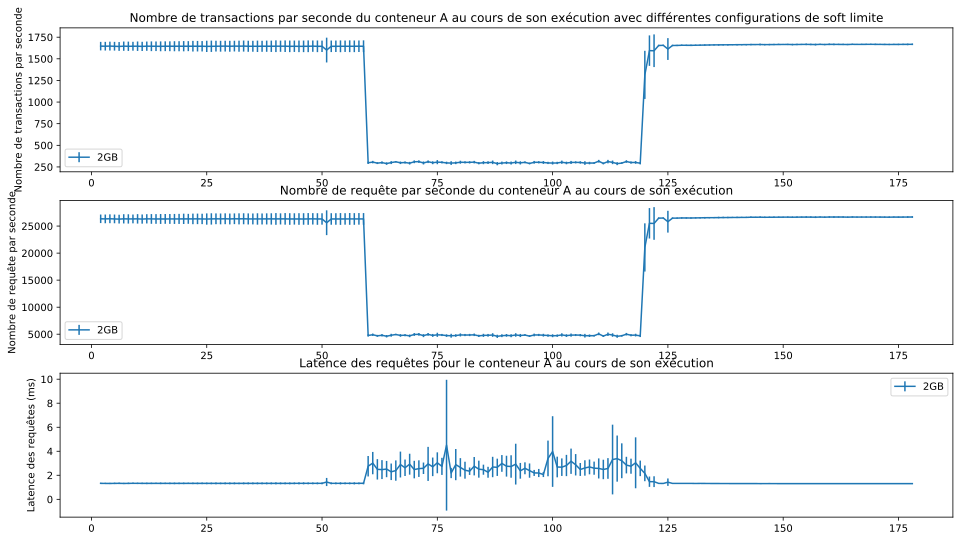

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats

DIR = 'results'
FILES = {'A': ['container_A_youthful_chaplygin_2000M.out.time.csv']}
KEYS = ['transactions', 'queries', 'latencies']

DURATION = 180
NAMES = ['2GB']

dictionnary = {}

for key in FILES:
    dictionnary[key] = {}
    
    for k in KEYS:
        dictionnary[key][k] = {'means': [], 'stds': []}
    
for key in FILES:
    for file in FILES[key]:
        # Get data from CSV file.
        df = pd.read_csv(DIR + '/' + file, ';')
        values = df.values

        for i in range(len(KEYS)):
            # The first record has strange standard deviation values so we do not get it.
            # For each key in KEYS there is two columns: the mean and the standard deviation.
            # The mean is the odd column and the standard deviation the even one.
            # The 'i * 2 + x' permits to take the good column for this key.
            dictionnary[key][KEYS[i]]['means'].append(values.take(i * 2 + 1, axis = 1)[2 : len(values) - 1])
            dictionnary[key][KEYS[i]]['stds'].append(values.take(i * 2 + 2, axis = 1)[2 : len(values) - 1])

# xtick labels for the bar chart.
x_pos = np.arange(len(range(DURATION)))

# sort the keys so order is correct.
sorted_keys = sorted(FILES.keys())

for key in sorted_keys:
    fig, (transactions_ax, queries_ax, latency_ax) = plt.subplots(nrows = 3, figsize = (16, 9))
    for i in range(len(NAMES)):
        transactions_ax.errorbar(x_pos[2 : len(x_pos) - 1], dictionnary[key]['transactions']['means'][i], yerr = dictionnary[key]['transactions']['stds'][i], label = NAMES[i])
        queries_ax.errorbar(x_pos[2 : len(x_pos) - 1], dictionnary[key]['queries']['means'][i], yerr = dictionnary[key]['queries']['stds'][i], label = NAMES[i])
        latency_ax.errorbar(x_pos[2 : len(x_pos) - 1], dictionnary[key]['latencies']['means'][i], yerr = dictionnary[key]['latencies']['stds'][i], label = NAMES[i])
    
        transactions_ax.legend()
        transactions_ax.set_ylabel('Nombre de transactions par seconde')
        transactions_ax.set_title('Nombre de transactions par seconde du conteneur %c au cours de son exécution avec différentes configurations de soft limite' % key)
    
        queries_ax.legend()
        queries_ax.set_ylabel('Nombre de requête par seconde')
        queries_ax.set_title('Nombre de requête par seconde du conteneur %c au cours de son exécution' % key)

        latency_ax.legend()
        latency_ax.set_ylabel('Latence des requêtes (ms)')
        latency_ax.set_title('Latence des requêtes pour le conteneur %c au cours de son exécution' % key)

# Print the figure.
set_matplotlib_formats('svg')
plt.show()

Les écarts-types sont très faibles ce qui indique donc que l'expérience est stable.
Quand le nombre de transaction n'est pas limité celui-ci vaut environ 1600.
Étrangement la latence augmente un peu quand le nombre de transactions est limité.

Regardons maintenant les performances globales du benchmark :

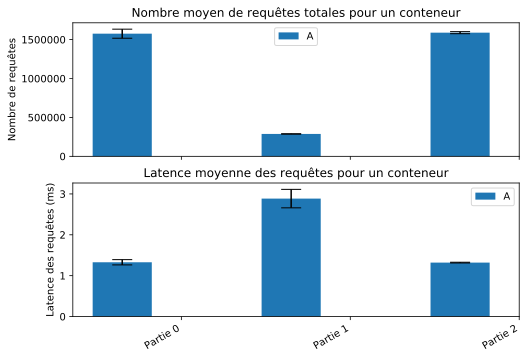

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats

DIR = 'results'
FILES = {'A': ['container_A_youthful_chaplygin_2000M.out.csv']}

# xtick labels for the bar chart.
NAMES = ['Partie 0', 'Partie 1', 'Partie 2']
# The width of the bars.
WIDTH = .35

dictionnary = {}

for key in FILES:
        dictionnary[key] = {'request': {'mean': [], 'std': []}, 'latency': {'mean': [], 'std': []}}
    
for key in FILES:
    for file in FILES[key]:
        # Get data from CSV file.
        df = pd.read_csv(DIR + '/' + file, ';')
        values = df.values

        for i in range(len(NAMES)):
            # Computing mean and standard deviation.
            # values is a numpy.ndarray i.e an array of tuples.
            # mean() and std() take an axis as argument and return a tuple.
            # [1] permits to obtain second member of tuple.
            # The queries are the first csv field (+ 1 because of the run column).
            dictionnary[key]['request']['mean'].append(values.mean(0)[1 + i])
            dictionnary[key]['request']['std'].append(values.std(0)[1 + i])
    
            # The latencies are the last csv field (+ 1 because of the run column and + len(NAMES) for the queries column).
            dictionnary[key]['latency']['mean'].append(values.mean(0)[1 + len(NAMES) + i])
            dictionnary[key]['latency']['std'].append(values.std(0)[1 + len(NAMES) + i])

x_pos = np.arange(len(NAMES))

# Axis and figure initialization.
fig, (request_ax, latency_ax) = plt.subplots(nrows = 2, figsize = (8, 6))

request_groups = []
latency_groups = []

# sort the keys so order is correct.
sorted_keys = sorted(FILES.keys())

for key in sorted_keys:
    request_groups.append(request_ax.bar(x_pos, dictionnary[key]['request']['mean'], WIDTH, yerr = dictionnary[key]['request']['std'], align = 'center', capsize = 10))
    latency_groups.append(latency_ax.bar(x_pos, dictionnary[key]['latency']['mean'], WIDTH, yerr = dictionnary[key]['latency']['std'], align = 'center', capsize = 10))         

    # Shift the position the second bar by width.
    x_pos = x_pos + WIDTH
    
request_ax.set_ylabel('Nombre de requêtes')
request_ax.set_xticks(x_pos)
request_ax.set_xticklabels(NAMES)
request_ax.legend(request_groups, sorted_keys)
request_ax.set_title("Nombre moyen de requêtes totales pour un conteneur")

latency_ax.set_ylabel('Latence des requêtes (ms)')
latency_ax.set_xticks(x_pos)
latency_ax.set_xticklabels(NAMES)
latency_ax.legend(latency_groups, sorted_keys)
latency_ax.set_title("Latence moyenne des requêtes pour un conteneur")

fig.autofmt_xdate()
# Print the figure.
set_matplotlib_formats('svg')
plt.show()

D'une manière globale lorsque le nombre de transaction n'est pas limitée le nombre de requêtes effectuées en 60 secondes est supérieur à 1.5 millions.

Intéressons nous maintenat à l'empreinte mémoire du conteneur et les lectures qu'il fait depuis le disque :

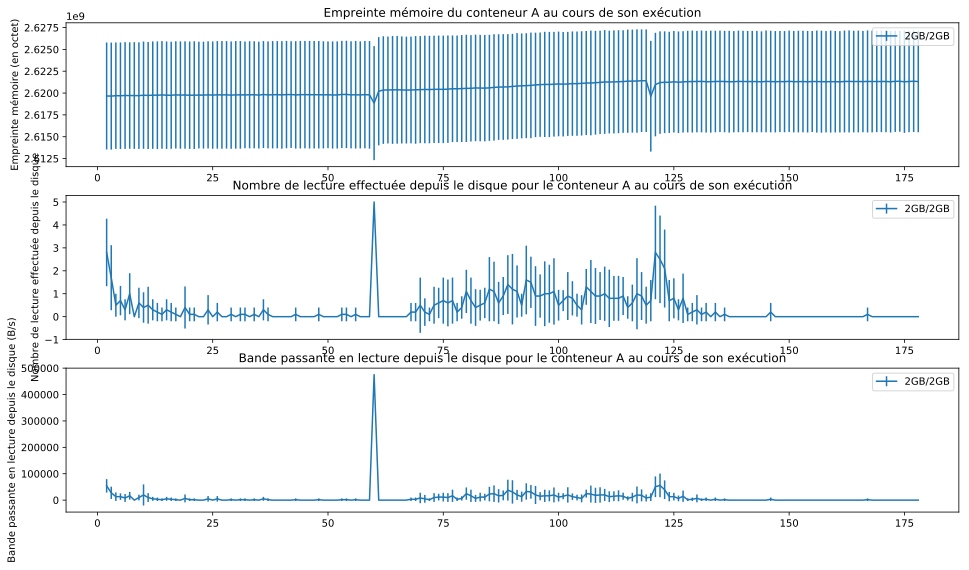

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats

NAMES = ['2GB/2GB']

DIR = 'results'
FILES = {'A': ['container_A_youthful_chaplygin_2000M.stats.csv']}

DURATION = 180

dictionnary = {}

for key in FILES:
    dictionnary[key] = {'usage': {'means': [], 'stds': []}, 'reads': {'means': [], 'stds': []}, 'read_bw': {'means': [], 'stds': []}}
    
for key in FILES:
    for file in FILES[key]:
        # Get data from CSV file.
        df = pd.read_csv(DIR + '/' + file, ';')
        values = df.values

        # The first record has strange standard deviation values so we do not get it.
        dictionnary[key]['usage']['means'].append(values.take(1, axis = 1)[2 : len(values) - 1])
        dictionnary[key]['usage']['stds'].append(values.take(2, axis = 1)[2 : len(values) - 1])

        dictionnary[key]['reads']['means'].append(values.take(13, axis = 1)[2 : len(values) - 1])
        dictionnary[key]['reads']['stds'].append(values.take(14, axis = 1)[2 : len(values) - 1])

        dictionnary[key]['read_bw']['means'].append(values.take(15, axis = 1)[2 : len(values) - 1])
        dictionnary[key]['read_bw']['stds'].append(values.take(16, axis = 1)[2 : len(values) - 1])

# xtick labels for the bar chart.
x_pos = np.arange(len(range(DURATION)))

# sort the keys so order is correct.
sorted_keys = sorted(FILES.keys())

for key in sorted_keys:
    fig, (usage_ax, reads_ax, read_bw_ax) = plt.subplots(nrows = 3, figsize = (16, 9))
    for i in range(len(NAMES)):
        usage_ax.errorbar(x_pos[2 : len(x_pos) - 1], dictionnary[key]['usage']['means'][i], yerr = dictionnary[key]['usage']['stds'][i], label = NAMES[i])
        reads_ax.errorbar(x_pos[2 : len(x_pos) - 1], dictionnary[key]['reads']['means'][i], yerr = dictionnary[key]['reads']['stds'][i], label = NAMES[i])
        read_bw_ax.errorbar(x_pos[2 : len(x_pos) - 1], dictionnary[key]['read_bw']['means'][i], yerr = dictionnary[key]['read_bw']['stds'][i], label = NAMES[i])
        
        usage_ax.legend()
        usage_ax.set_ylabel('Empreinte mémoire (en octet)')
        usage_ax.set_title('Empreinte mémoire du conteneur %c au cours de son exécution' % key)

        reads_ax.legend()
        reads_ax.set_ylabel('Nombre de lecture effectuée depuis le disque')
        reads_ax.set_title('Nombre de lecture effectuée depuis le disque pour le conteneur %c au cours de son exécution' % key)

        read_bw_ax.legend()
        read_bw_ax.set_ylabel('Bande passante en lecture depuis le disque (B/s)')
        read_bw_ax.set_title('Bande passante en lecture depuis le disque pour le conteneur %c au cours de son exécution' % key)
        
# Print the figure.
set_matplotlib_formats('svg')
plt.show()

Puisque la base de donnée est déjà en mémoire l'empreinte mémoire de ce conteneur est assez conséquent et vaut environ 2.6GB.
Le nombre nul de lecture effectuée depuis le disque a aussi pour origine le fait que la base de donnée ait été ramenée en mémoire.

#### Conclusion
Les chiffres obtenus serviront de base pour des expériences avec deux conteneurs.